In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import cv2
import torch
import os
import sys
from torchvision import models
import torch.nn as nn
import torchsummary

In [2]:
import os


current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, ".."))
if project_root not in sys.path:
    sys.path.append(project_root)
BASE_DIR = os.path.basename(project_root)

## 1. Construct Dataset with Fourier Transform

In [81]:
def fft_mag_image(split, image_path, target_image_size):
    # Image path: Image

    pil_image = Image.open(image_path).convert("RGB")
    gray = np.array(pil_image.convert("L"))
    gray_resize = cv2.resize(gray, target_image_size)
    F = np.fft.fft2(gray_resize)
    F_shift = np.fft.fftshift(F)

    # Apply log1p to avoid large exponential
    log_mag = np.log1p(np.abs(F_shift))

    # Normalize down to range [0, 1]
    mag_norm = (log_mag - log_mag.min()) / (log_mag.max() - log_mag.min())

    image_name = image_path.split("/")[-1].split(".")[0]
    # Save in format: fourier/split/image_name.npy
    # Save this in npy format
    split_path = os.path.join(f"{project_root}/fourier", split)
    os.makedirs(split_path, exist_ok=True)
    save_path = f"{project_root}/fourier/{split}/{image_name}"
    np.save(save_path, mag_norm)


splits = ["train", "val", "test"]

for split in splits:
    split_path = os.path.join(f"{project_root}/data", split)
    for label in os.listdir(split_path):
        label_path = os.path.join(split_path, label)
        for item in os.listdir(label_path):
            item_path = os.path.join(label_path, item)
            fft_mag_image(split, item_path, target_image_size=(224, 224))

In [33]:

from src.dataloader import get_data_loaders
from src.train import train_one_epoch, evaluate
from src.utils import (
    set_seed,
    save_checkpoint,
    save_experiment_json,
    get_device,
    plot_history,
    error_analysis,
    plot_error_analysis
    
)

In [4]:
CLASS = ["real", "fake"]
BATCH_SIZE = 32
DEVICE = get_device()
TASK_NAME = "deepfake_detection"
EPOCHS_STAGE_1 = 10  # General configuration
LR_STAGE_1 = 1e-3  # General configuration
EPOCHS_STAGE_2 = 20  # General configuration
LR_STAGE_2 = 1e-5  # General configuration
MODEL_NAME = "efficient-net"
set_seed(42)
print(f"Using device: {DEVICE}")

Using device: mps


In [5]:
data_path = os.path.join(project_root, "data")

## 2. Efficient Net

### 2.1 Settings 1: Train fourier transform extractor first + Fine-tune the entire model

In [6]:

train_loader, val_loader, test_loader = get_data_loaders(
    data_path,
    MODEL_NAME,
    BATCH_SIZE,
    use_fourier_transform=True,
    use_augmentation=True
)

/Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/.venv/lib/python3.11/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [83]:
from tqdm import tqdm
from sklearn.metrics import f1_score, roc_auc_score
import torch.nn.functional as F


def train_step(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    loop = tqdm(dataloader, desc="Training")

    for _, fourier_mags, images, labels in loop:
        images = images.to(device)
        labels = labels.to(device)
        fourier_mags = fourier_mags.to(device)
        optimizer.zero_grad()

        outputs = model(fourier_mags, images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)

        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)

        loop.set_postfix(loss=loss.item())

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples

    return epoch_loss, epoch_acc


def evaluate_step(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    all_labels = []
    all_preds = []
    all_probs_real = []

    with torch.no_grad():
        for _, fourier_mags, images, labels in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)
            labels = labels.to(device)
            fourier_mags = fourier_mags.to(device)
            outputs = model(fourier_mags, images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)

            _, preds = torch.max(outputs, 1)
            probs = F.softmax(outputs, dim=1)

            correct_predictions += (preds == labels).sum().item()
            total_samples += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs_real.extend(probs[:, 1].cpu().numpy())

    avg_loss = running_loss / total_samples
    avg_acc = correct_predictions / total_samples

    f1 = f1_score(all_labels, all_preds, average="binary")

    try:
        auc = roc_auc_score(all_labels, all_probs_real)
    except ValueError:
        auc = 0.0

    return avg_loss, avg_acc, f1, auc

In [84]:
import torch.nn.functional as F
class EfficientNetDFWithFourier(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()

        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

        # Freeze all model weights
        for param in model.parameters():
            param.requires_grad = False

        # Remove the classifier layer in model
        self.feature_extractor = nn.Sequential()
        for name, module in model.named_children():
            if name == "classifier":
                break
            self.feature_extractor.add_module(name, module)

        self.fourier_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(output_size=1),
        )

        num_features = model.classifier[1].in_features + 32

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=True), nn.Linear(num_features, num_classes)
        )

    def forward(self, fourier_mag, img):
        img_features = self.feature_extractor(img)
        img_features_flatten = torch.flatten(img_features, start_dim=1)
        fourier_features = self.fourier_extractor(fourier_mag)
        fourier_features_flatten = torch.flatten(fourier_features, start_dim=1)
        
        # Normalize the features to the same scale
        img_features_flatten_normalize = F.normalize(img_features_flatten, dim=1)
        fourier_features_flatten_normalize = F.normalize(fourier_features_flatten, dim=1)
        
        concat_features = torch.concat(
            (img_features_flatten_normalize, fourier_features_flatten_normalize), dim=1
        )
        output = self.classifier(concat_features)
        return output

In [85]:
model = EfficientNetDFWithFourier()

# Get number of trained parameters for this model
def get_num_trained_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of trained parameters: {get_num_trained_parameters(model)}")


Number of trained parameters: 12322


In [86]:
model = model.to(device=DEVICE)
LABEL_SMOOTHING = 0.1
WEIGHT_DECAY = 1e-2

optimizer = torch.optim.Adam(
    params=model.parameters(), lr=LR_STAGE_1, weight_decay=WEIGHT_DECAY
)
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)

In [87]:
history_aug = {
    "model_name": MODEL_NAME,
    "model_saved_path": "",
    "weight_decay": WEIGHT_DECAY,
    "label_smoothing": LABEL_SMOOTHING,
    "train_losses": [],
    "val_losses": [],
    "train_accuracy": [],
    "val_accuracy": [],
    "val_f1": [],
    "val_auc": [],
    "best_accuracy": [],
    "best_epoch": [],
}

best_acc = 0.0

In [88]:
MODEL_SAVED_PATH = os.path.join(
    project_root, f"model_checkpoints/{MODEL_NAME}_{TASK_NAME}_augmentation_fourier.pth"
)

print(
    f"Training configuration for stage 1: LR = {LR_STAGE_1}, EPOCHS = {EPOCHS_STAGE_1}"
)

for epoch in range(EPOCHS_STAGE_1):
    # Train
    train_loss, train_acc = train_step(
        model, train_loader, criterion, optimizer, DEVICE
    )

    # Evaluate
    valid_loss, valid_acc, valid_f1, valid_auc = evaluate_step(
        model, val_loader, criterion, DEVICE
    )

    print(
        f"[{epoch + 1}/{EPOCHS_STAGE_1}] train_acc: {train_acc:.4f} - train_loss: {train_loss:.4f} - valid_acc: {valid_acc:.4f} - valid_loss: {valid_loss:.4f}"
    )
    # Record metrics
    history_aug["train_losses"].append(train_loss)
    history_aug["val_losses"].append(valid_loss)
    history_aug["train_accuracy"].append(train_acc)
    history_aug["val_accuracy"].append(valid_acc)
    history_aug["val_f1"].append(valid_f1)
    history_aug["val_auc"].append(valid_auc)

    # Save Best Model (based on Accuracy)
    if valid_acc > best_acc:
        best_acc = valid_acc
        save_checkpoint(model, optimizer, MODEL_SAVED_PATH)

        # Update best stats
        history_aug["best_accuracy"] = best_acc
        history_aug["best_epoch"] = epoch + 1
        history_aug["MODEL_SAVED_PATH"] = MODEL_SAVED_PATH

    print(
        f"\t- [current best] epoch: {history_aug['best_epoch']} - acc: {history_aug['best_accuracy']:.4f}\n"
    )

Training configuration for stage 1: LR = 0.001, EPOCHS = 10


Evaluating: 100%|██████████| 94/94 [00:55<00:00,  1.69it/s]


[1/10] train_acc: 0.5976 - train_loss: 0.6811 - valid_acc: 0.5997 - valid_loss: 0.6783
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/efficient-net_deepfake_detection_augmentation_fourier.pth
	- [current best] epoch: 1 - acc: 0.5997



Evaluating: 100%|██████████| 94/94 [00:56<00:00,  1.67it/s]


[2/10] train_acc: 0.6165 - train_loss: 0.6767 - valid_acc: 0.6124 - valid_loss: 0.6761
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/efficient-net_deepfake_detection_augmentation_fourier.pth
	- [current best] epoch: 2 - acc: 0.6124



Evaluating: 100%|██████████| 94/94 [00:58<00:00,  1.60it/s]


[3/10] train_acc: 0.6161 - train_loss: 0.6766 - valid_acc: 0.5866 - valid_loss: 0.6788
	- [current best] epoch: 2 - acc: 0.6124



Evaluating: 100%|██████████| 94/94 [00:46<00:00,  2.03it/s]


[4/10] train_acc: 0.6103 - train_loss: 0.6766 - valid_acc: 0.6265 - valid_loss: 0.6758
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/efficient-net_deepfake_detection_augmentation_fourier.pth
	- [current best] epoch: 4 - acc: 0.6265



Evaluating: 100%|██████████| 94/94 [00:48<00:00,  1.94it/s]


[5/10] train_acc: 0.6091 - train_loss: 0.6765 - valid_acc: 0.5601 - valid_loss: 0.6786
	- [current best] epoch: 4 - acc: 0.6265



Evaluating: 100%|██████████| 94/94 [00:48<00:00,  1.94it/s]


[6/10] train_acc: 0.6089 - train_loss: 0.6759 - valid_acc: 0.6138 - valid_loss: 0.6751
	- [current best] epoch: 4 - acc: 0.6265



Evaluating: 100%|██████████| 94/94 [00:54<00:00,  1.72it/s]


[7/10] train_acc: 0.6125 - train_loss: 0.6755 - valid_acc: 0.6225 - valid_loss: 0.6743
	- [current best] epoch: 4 - acc: 0.6265



Evaluating: 100%|██████████| 94/94 [01:02<00:00,  1.50it/s]


[8/10] train_acc: 0.6118 - train_loss: 0.6762 - valid_acc: 0.5906 - valid_loss: 0.6761
	- [current best] epoch: 4 - acc: 0.6265



Evaluating: 100%|██████████| 94/94 [01:02<00:00,  1.51it/s]


[9/10] train_acc: 0.6052 - train_loss: 0.6762 - valid_acc: 0.5909 - valid_loss: 0.6770
	- [current best] epoch: 4 - acc: 0.6265



Evaluating: 100%|██████████| 94/94 [00:53<00:00,  1.75it/s]

[10/10] train_acc: 0.6060 - train_loss: 0.6759 - valid_acc: 0.5520 - valid_loss: 0.6797
	- [current best] epoch: 4 - acc: 0.6265



In [89]:
# Load the best state again
checkpoint = torch.load(MODEL_SAVED_PATH)
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

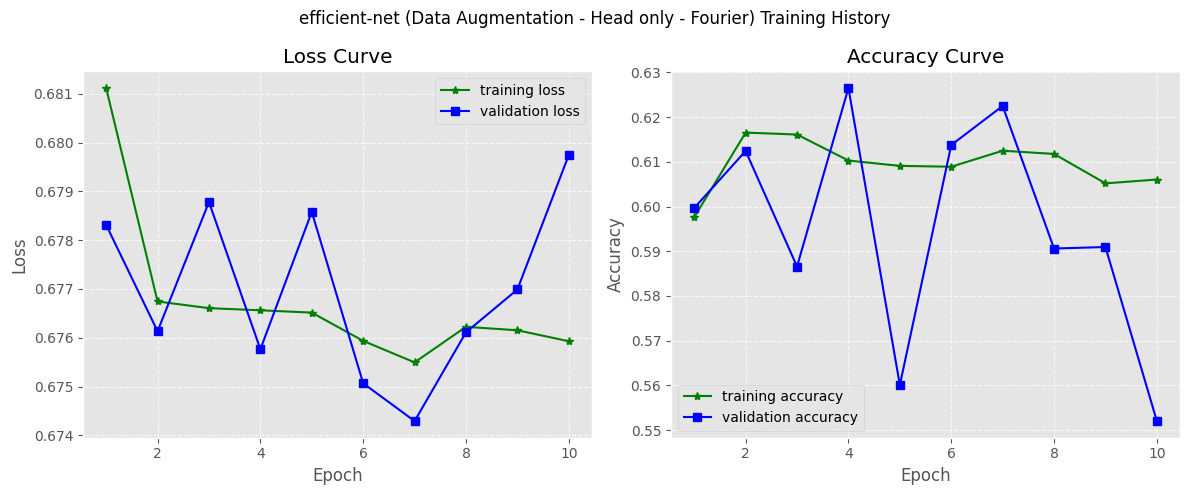

In [90]:
model_saved_name = f"{project_root}/results/{MODEL_NAME}_{TASK_NAME}_augmentation_fourier"
plot_history(
    history_aug,
    f"{MODEL_NAME} (Data Augmentation - Head only - Fourier) Training History",
    f"{model_saved_name}.png",
)

In [91]:
for param in model.parameters():
    param.requires_grad = True

print(f"Number of trained parameters: {get_num_trained_parameters(model)}")

Number of trained parameters: 4019870


In [92]:
LABEL_SMOOTHING = 0.1
WEIGHT_DECAY = 1e-2

In [93]:
model = model.to(device=DEVICE)


optimizer = torch.optim.Adam(
    params=model.parameters(), lr=LR_STAGE_2, weight_decay=WEIGHT_DECAY
)
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)

In [94]:
TOTAL_EPOCHS = EPOCHS_STAGE_1 + EPOCHS_STAGE_2
model_save_path = (
    f"{project_root}/model_checkpoints/best_{MODEL_NAME}_{TASK_NAME}_augmentation_fourier_finetuned.pth"
)

print(
    f"Training configuration for stage 2: LR = {LR_STAGE_2}, EPOCHS = {EPOCHS_STAGE_2}"
)
for epoch in range(EPOCHS_STAGE_1, TOTAL_EPOCHS):
    train_loss, train_acc = train_step(
        model, train_loader, criterion, optimizer, DEVICE
    )
    valid_loss, valid_acc, valid_f1, valid_auc = evaluate_step(
        model, val_loader, criterion, DEVICE
    )

    print(
        f"[{epoch + 1}/{TOTAL_EPOCHS} (Fine-Tune)] train_acc: {train_acc:.4f} - train_loss: {train_loss:.4f} - valid_acc: {valid_acc:.4f} - valid_loss: {valid_loss:.4f}"
    )

    # Record metrics
    history_aug["train_losses"].append(train_loss)
    history_aug["val_losses"].append(valid_loss)
    history_aug["train_accuracy"].append(train_acc)
    history_aug["val_accuracy"].append(valid_acc)
    history_aug["val_f1"].append(valid_f1)
    history_aug["val_auc"].append(valid_auc)

    # Save Best Model (based on Accuracy)
    if valid_acc > best_acc:
        best_acc = valid_acc
        save_checkpoint(model, optimizer, model_save_path)

        # Update best stats
        history_aug["best_accuracy"] = best_acc
        history_aug["best_epoch"] = epoch + 1
        history_aug["MODEL_SAVED_PATH"] = model_save_path

    print(
        f"\t- [current best] epoch: {history_aug['best_epoch']} - acc: {history_aug['best_accuracy']:.4f}\n"
    )

Training configuration for stage 2: LR = 1e-05, EPOCHS = 20


Evaluating: 100%|██████████| 94/94 [00:51<00:00,  1.84it/s]


[11/30 (Fine-Tune)] train_acc: 0.6484 - train_loss: 0.6695 - valid_acc: 0.6758 - valid_loss: 0.6582
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_efficient-net_deepfake_detection_augmentation_fourier_finetuned.pth
	- [current best] epoch: 11 - acc: 0.6758



Evaluating: 100%|██████████| 94/94 [00:48<00:00,  1.92it/s]


[12/30 (Fine-Tune)] train_acc: 0.6878 - train_loss: 0.6446 - valid_acc: 0.7262 - valid_loss: 0.6188
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_efficient-net_deepfake_detection_augmentation_fourier_finetuned.pth
	- [current best] epoch: 12 - acc: 0.7262



Evaluating: 100%|██████████| 94/94 [01:01<00:00,  1.54it/s]


[13/30 (Fine-Tune)] train_acc: 0.7386 - train_loss: 0.5987 - valid_acc: 0.7658 - valid_loss: 0.5647
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_efficient-net_deepfake_detection_augmentation_fourier_finetuned.pth
	- [current best] epoch: 13 - acc: 0.7658



Evaluating: 100%|██████████| 94/94 [00:53<00:00,  1.76it/s]


[14/30 (Fine-Tune)] train_acc: 0.7827 - train_loss: 0.5469 - valid_acc: 0.8141 - valid_loss: 0.5151
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_efficient-net_deepfake_detection_augmentation_fourier_finetuned.pth
	- [current best] epoch: 14 - acc: 0.8141



Evaluating: 100%|██████████| 94/94 [00:44<00:00,  2.09it/s]


[15/30 (Fine-Tune)] train_acc: 0.8215 - train_loss: 0.4979 - valid_acc: 0.8460 - valid_loss: 0.4690
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_efficient-net_deepfake_detection_augmentation_fourier_finetuned.pth
	- [current best] epoch: 15 - acc: 0.8460



Evaluating: 100%|██████████| 94/94 [00:57<00:00,  1.63it/s]


[16/30 (Fine-Tune)] train_acc: 0.8481 - train_loss: 0.4558 - valid_acc: 0.8604 - valid_loss: 0.4399
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_efficient-net_deepfake_detection_augmentation_fourier_finetuned.pth
	- [current best] epoch: 16 - acc: 0.8604



Evaluating: 100%|██████████| 94/94 [00:48<00:00,  1.94it/s]


[17/30 (Fine-Tune)] train_acc: 0.8647 - train_loss: 0.4259 - valid_acc: 0.8691 - valid_loss: 0.4197
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_efficient-net_deepfake_detection_augmentation_fourier_finetuned.pth
	- [current best] epoch: 17 - acc: 0.8691



Evaluating: 100%|██████████| 94/94 [00:47<00:00,  1.98it/s]


[18/30 (Fine-Tune)] train_acc: 0.8784 - train_loss: 0.4056 - valid_acc: 0.8782 - valid_loss: 0.4049
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_efficient-net_deepfake_detection_augmentation_fourier_finetuned.pth
	- [current best] epoch: 18 - acc: 0.8782



Evaluating: 100%|██████████| 94/94 [00:49<00:00,  1.90it/s]


[19/30 (Fine-Tune)] train_acc: 0.8904 - train_loss: 0.3826 - valid_acc: 0.8883 - valid_loss: 0.3894
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_efficient-net_deepfake_detection_augmentation_fourier_finetuned.pth
	- [current best] epoch: 19 - acc: 0.8883



Evaluating: 100%|██████████| 94/94 [01:15<00:00,  1.24it/s]


[20/30 (Fine-Tune)] train_acc: 0.8999 - train_loss: 0.3676 - valid_acc: 0.8829 - valid_loss: 0.3904
	- [current best] epoch: 19 - acc: 0.8883



Evaluating: 100%|██████████| 94/94 [00:45<00:00,  2.06it/s]


[21/30 (Fine-Tune)] train_acc: 0.9079 - train_loss: 0.3541 - valid_acc: 0.8946 - valid_loss: 0.3776
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_efficient-net_deepfake_detection_augmentation_fourier_finetuned.pth
	- [current best] epoch: 21 - acc: 0.8946



Evaluating: 100%|██████████| 94/94 [00:48<00:00,  1.92it/s]


[22/30 (Fine-Tune)] train_acc: 0.9131 - train_loss: 0.3438 - valid_acc: 0.8950 - valid_loss: 0.3767
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_efficient-net_deepfake_detection_augmentation_fourier_finetuned.pth
	- [current best] epoch: 22 - acc: 0.8950



Evaluating: 100%|██████████| 94/94 [00:59<00:00,  1.58it/s]


[23/30 (Fine-Tune)] train_acc: 0.9196 - train_loss: 0.3337 - valid_acc: 0.8990 - valid_loss: 0.3727
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_efficient-net_deepfake_detection_augmentation_fourier_finetuned.pth
	- [current best] epoch: 23 - acc: 0.8990



Evaluating: 100%|██████████| 94/94 [01:01<00:00,  1.52it/s]


[24/30 (Fine-Tune)] train_acc: 0.9255 - train_loss: 0.3250 - valid_acc: 0.8909 - valid_loss: 0.3726
	- [current best] epoch: 23 - acc: 0.8990



Evaluating: 100%|██████████| 94/94 [01:04<00:00,  1.46it/s]


[25/30 (Fine-Tune)] train_acc: 0.9286 - train_loss: 0.3167 - valid_acc: 0.8936 - valid_loss: 0.3716
	- [current best] epoch: 23 - acc: 0.8990



Evaluating: 100%|██████████| 94/94 [00:48<00:00,  1.92it/s]


[26/30 (Fine-Tune)] train_acc: 0.9331 - train_loss: 0.3110 - valid_acc: 0.9007 - valid_loss: 0.3656
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_efficient-net_deepfake_detection_augmentation_fourier_finetuned.pth
	- [current best] epoch: 26 - acc: 0.9007



Evaluating: 100%|██████████| 94/94 [00:49<00:00,  1.90it/s]


[27/30 (Fine-Tune)] train_acc: 0.9354 - train_loss: 0.3083 - valid_acc: 0.8919 - valid_loss: 0.3774
	- [current best] epoch: 26 - acc: 0.9007



Evaluating: 100%|██████████| 94/94 [01:14<00:00,  1.26it/s]


[28/30 (Fine-Tune)] train_acc: 0.9392 - train_loss: 0.3010 - valid_acc: 0.9044 - valid_loss: 0.3606
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_efficient-net_deepfake_detection_augmentation_fourier_finetuned.pth
	- [current best] epoch: 28 - acc: 0.9044



Evaluating: 100%|██████████| 94/94 [01:15<00:00,  1.25it/s]


[29/30 (Fine-Tune)] train_acc: 0.9426 - train_loss: 0.2952 - valid_acc: 0.9000 - valid_loss: 0.3723
	- [current best] epoch: 28 - acc: 0.9044



Evaluating: 100%|██████████| 94/94 [01:14<00:00,  1.25it/s]

[30/30 (Fine-Tune)] train_acc: 0.9441 - train_loss: 0.2945 - valid_acc: 0.8960 - valid_loss: 0.3708
	- [current best] epoch: 28 - acc: 0.9044



In [100]:
EPOCHS_STAGE_3 = 10
LR_STAGE_3 = 1e-5

optimizer = torch.optim.Adam(
    params=model.parameters(), lr=LR_STAGE_3, weight_decay=WEIGHT_DECAY
)
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)

In [101]:
# Continue fine-tuning the model
TOTAL_EPOCHS_PREV = EPOCHS_STAGE_1 + EPOCHS_STAGE_2
TOTAL_EPOCHS = TOTAL_EPOCHS_PREV + EPOCHS_STAGE_3
model_save_path = (
    f"{project_root}/model_checkpoints/best_{MODEL_NAME}_{TASK_NAME}_augmentation_fourier_finetuned.pth"
)

print(
    f"Training configuration for stage 3: LR = {LR_STAGE_3}, EPOCHS = {EPOCHS_STAGE_3}"
)
for epoch in range(TOTAL_EPOCHS_PREV, TOTAL_EPOCHS):
    train_loss, train_acc = train_step(
        model, train_loader, criterion, optimizer, DEVICE
    )
    valid_loss, valid_acc, valid_f1, valid_auc = evaluate_step(
        model, val_loader, criterion, DEVICE
    )

    print(
        f"[{epoch + 1}/{TOTAL_EPOCHS} (Fine-Tune)] train_acc: {train_acc:.4f} - train_loss: {train_loss:.4f} - valid_acc: {valid_acc:.4f} - valid_loss: {valid_loss:.4f}"
    )

    # Record metrics
    history_aug["train_losses"].append(train_loss)
    history_aug["val_losses"].append(valid_loss)
    history_aug["train_accuracy"].append(train_acc)
    history_aug["val_accuracy"].append(valid_acc)
    history_aug["val_f1"].append(valid_f1)
    history_aug["val_auc"].append(valid_auc)

    # Save Best Model (based on Accuracy)
    if valid_acc > best_acc:
        best_acc = valid_acc
        save_checkpoint(model, optimizer, model_save_path)

        # Update best stats
        history_aug["best_accuracy"] = best_acc
        history_aug["best_epoch"] = epoch + 1
        history_aug["MODEL_SAVED_PATH"] = model_save_path

    print(
        f"\t- [current best] epoch: {history_aug['best_epoch']} - acc: {history_aug['best_accuracy']:.4f}\n"
    )

Training configuration for stage 3: LR = 1e-05, EPOCHS = 10


Evaluating: 100%|██████████| 94/94 [00:48<00:00,  1.92it/s]


[31/40 (Fine-Tune)] train_acc: 0.9418 - train_loss: 0.2961 - valid_acc: 0.9057 - valid_loss: 0.3598
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_efficient-net_deepfake_detection_augmentation_fourier_finetuned.pth
	- [current best] epoch: 31 - acc: 0.9057



Evaluating: 100%|██████████| 94/94 [00:47<00:00,  1.97it/s]


[32/40 (Fine-Tune)] train_acc: 0.9466 - train_loss: 0.2913 - valid_acc: 0.9010 - valid_loss: 0.3690
	- [current best] epoch: 31 - acc: 0.9057



Evaluating: 100%|██████████| 94/94 [00:50<00:00,  1.87it/s]


[33/40 (Fine-Tune)] train_acc: 0.9457 - train_loss: 0.2897 - valid_acc: 0.9010 - valid_loss: 0.3710
	- [current best] epoch: 31 - acc: 0.9057



Evaluating: 100%|██████████| 94/94 [00:50<00:00,  1.85it/s]


[34/40 (Fine-Tune)] train_acc: 0.9487 - train_loss: 0.2832 - valid_acc: 0.9050 - valid_loss: 0.3632
	- [current best] epoch: 31 - acc: 0.9057



Evaluating: 100%|██████████| 94/94 [00:51<00:00,  1.83it/s]


[35/40 (Fine-Tune)] train_acc: 0.9513 - train_loss: 0.2807 - valid_acc: 0.9070 - valid_loss: 0.3585
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_efficient-net_deepfake_detection_augmentation_fourier_finetuned.pth
	- [current best] epoch: 35 - acc: 0.9070



Evaluating: 100%|██████████| 94/94 [00:53<00:00,  1.75it/s]


[36/40 (Fine-Tune)] train_acc: 0.9546 - train_loss: 0.2770 - valid_acc: 0.9077 - valid_loss: 0.3545
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_efficient-net_deepfake_detection_augmentation_fourier_finetuned.pth
	- [current best] epoch: 36 - acc: 0.9077



Evaluating: 100%|██████████| 94/94 [00:55<00:00,  1.70it/s]


[37/40 (Fine-Tune)] train_acc: 0.9551 - train_loss: 0.2764 - valid_acc: 0.9037 - valid_loss: 0.3656
	- [current best] epoch: 36 - acc: 0.9077



Evaluating: 100%|██████████| 94/94 [01:26<00:00,  1.09it/s]


[38/40 (Fine-Tune)] train_acc: 0.9543 - train_loss: 0.2767 - valid_acc: 0.9111 - valid_loss: 0.3546
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_efficient-net_deepfake_detection_augmentation_fourier_finetuned.pth
	- [current best] epoch: 38 - acc: 0.9111



Evaluating: 100%|██████████| 94/94 [00:50<00:00,  1.85it/s]


[39/40 (Fine-Tune)] train_acc: 0.9557 - train_loss: 0.2750 - valid_acc: 0.9074 - valid_loss: 0.3625
	- [current best] epoch: 38 - acc: 0.9111



Evaluating: 100%|██████████| 94/94 [00:43<00:00,  2.16it/s]

[40/40 (Fine-Tune)] train_acc: 0.9586 - train_loss: 0.2711 - valid_acc: 0.9044 - valid_loss: 0.3670
	- [current best] epoch: 38 - acc: 0.9111



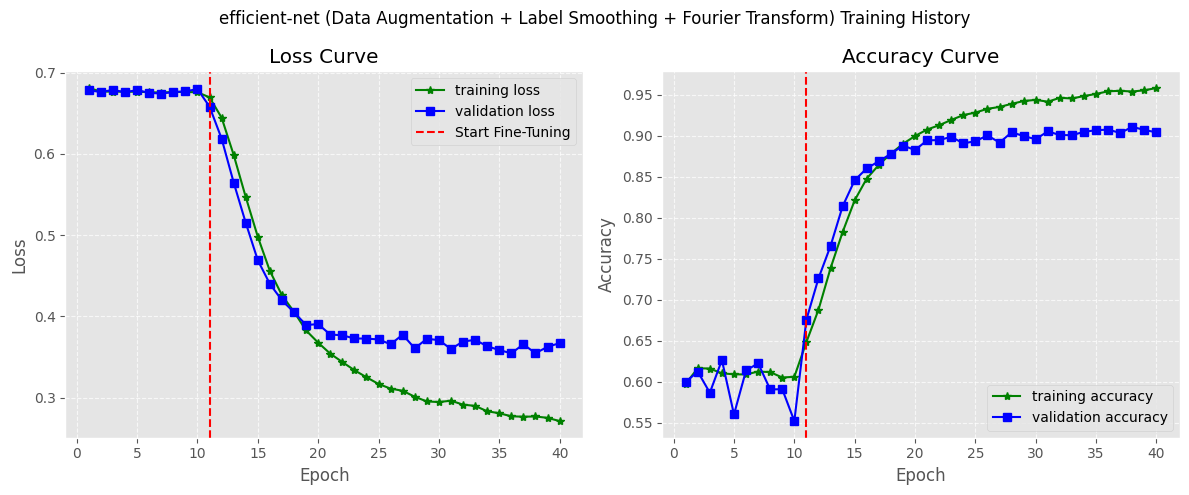

In [102]:
model_saved_name = (
    f"{project_root}/results/{MODEL_NAME}_augmentation_fourier_finetuned_{TASK_NAME}"
)
plot_history(
    history_aug,
    f"{MODEL_NAME} (Data Augmentation + Label Smoothing + Fourier Transform) Training History",
    f"{model_saved_name}.png",
    start_finetuned_epoch=EPOCHS_STAGE_1 + 1,
)

In [103]:
# Load the model again
checkpoint = torch.load(model_save_path)
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
def get_all_predictions(model, loader, device):
    """
    Runs inference on the entire loader and returns all true labels and predictions.
    """
    model.eval()
    y_pred = []
    y_true = []
    originals = []
    with torch.no_grad():
        for original_batch, fourier_mags, images, labels in tqdm(loader, desc="Getting predictions"):
            images = images.to(device)
            labels = labels.to(device)
            fourier_mags = fourier_mags.to(device)
            outputs = model(fourier_mags, images)
            _, preds = torch.max(outputs, 1)

            originals.extend(original_batch.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    return originals, y_true, y_pred


def performance(
    model, loader, device, model_name, save_path=None, class_names=["real", "fake"]
):
    from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

    _, y_true, y_pred = get_all_predictions(model, loader, device)

    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy score: {acc:.4f}")

    print("Classification Report")
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="crest",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{model_name} Confusion Matrix")
    if save_path is not None:
        plt.savefig(save_path)
    plt.tight_layout()
    plt.show()

Getting predictions: 100%|██████████| 95/95 [00:52<00:00,  1.80it/s]

Accuracy score: 0.9083
Classification Report
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1510
           1       0.91      0.91      0.91      1510

    accuracy                           0.91      3020
   macro avg       0.91      0.91      0.91      3020
weighted avg       0.91      0.91      0.91      3020



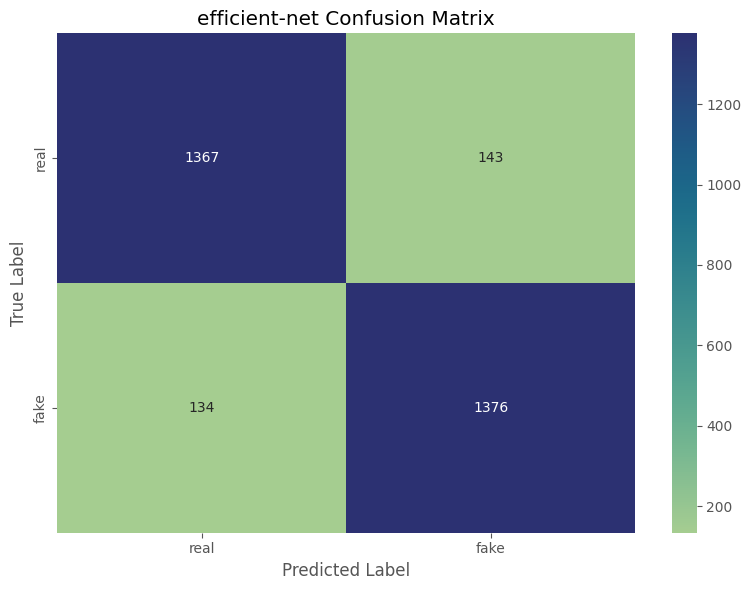

In [ ]:
save_path = (
    f"{project_root}/results/{MODEL_NAME}_{TASK_NAME}_augmentation_fourier_finetuned_cfm.png"
)
performance(model, test_loader, DEVICE, MODEL_NAME, save_path=save_path)

In [106]:
json_path = os.path.join(project_root, f"results/{MODEL_NAME}_{TASK_NAME}_augmentation_fourier_finetuned_history.json")
save_experiment_json(history_aug, json_path)

History saved to /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/results/efficient-net_deepfake_detection_augmentation_fourier_finetuned_history.json


In [ ]:
model_save_path = (
    f"{project_root}/model_checkpoints/best_{MODEL_NAME}_{TASK_NAME}_augmentation_fourier_finetuned.pth"
)
checkpoint = torch.load(model_save_path, map_location=DEVICE)
model.load_state_dict(checkpoint["state_dict"])


Deepfakes : 0.9470
Face2Face : 0.9272
FaceSwap : 0.8907
FaceShifter : 0.9205
NeuralTextures : 0.8709


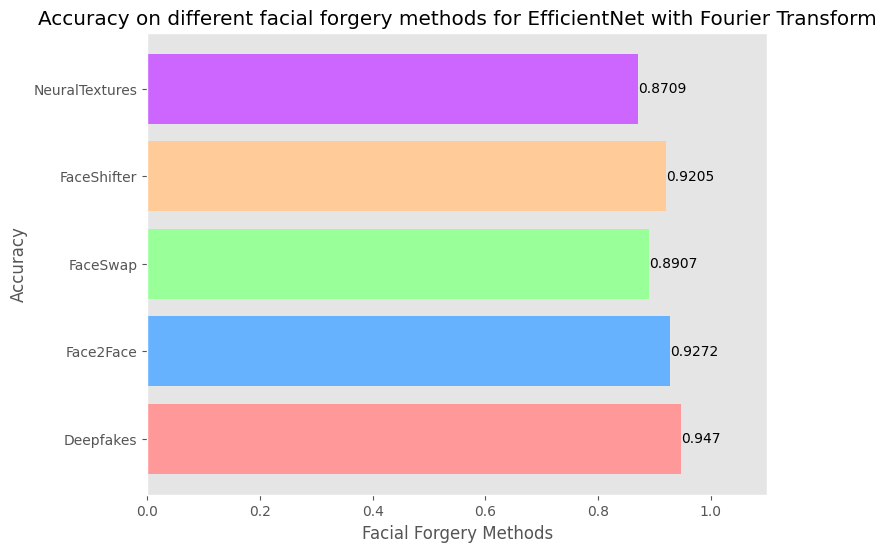

In [105]:
summary = error_analysis(model = model, fake_image_path = f"{project_root}/data/test/fake", model_name = MODEL_NAME, device = DEVICE, use_fourier_transform=True)
plot_error_analysis(summary, model_name = "EfficientNet with Fourier Transform")